In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES = 3

# Necessary imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
from torch.utils.data import random_split
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../seismiqb/')
from batchflow import Pipeline, Notifier, set_gpus
from batchflow import B, C, P, R, M, V, D
from batchflow.models.torch import TorchModel, ResBlock

from seismiqb import SeismicDataset, Horizon
from seismiqb import SeismicSampler, Accumulator3D, RegularGrid
from seismiqb import plot

# Set GPU
set_gpus(n=1, min_free_memory=0.4);

env: CUDA_VISIBLE_DEVICES=3


In [2]:
DEVICE = 'cuda:0'
N_ITERS = 300

In [3]:
# Global parameters
CROP_SHAPE = (1, 256, 256)       # shape of sampled 3D crops
BATCH_SIZE = 32                  # number of crops inside one batch

In [4]:
cube_path = '/notebooks/cubes/001_YETYPUR/001_YETYPUR.qblosc'

dataset = SeismicDataset(cube_path)
field = dataset[0]

In [5]:
print(field.geometry)


Processed geometry for cube    /notebooks/cubes/001_YETYPUR/001_YETYPUR.qblosc
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Cube shape:                    (2563, 1409, 1501)
Time delay:                    50
Sample rate:                   2.0
Area:                          1522.4 km²

SEG-Y original size:           21.000 GB
Current cube size:             4.910 GB
Size of the instance:          0.129 GB

Number of traces:              3611267
Number of non-zero traces:     2435820
Fullness:                      0.67

Original cube values:
Number of uniques:                    192
mean | std:                          0.12 | 1887.29   
min | max:                      -47429.45 | 39240.19  
q01 | q99:                       -5459.50 | 5118.29   

Quantized cube info:
Error of quantization:              0.041
Ranges:                          -5118.29 | 5118.29   



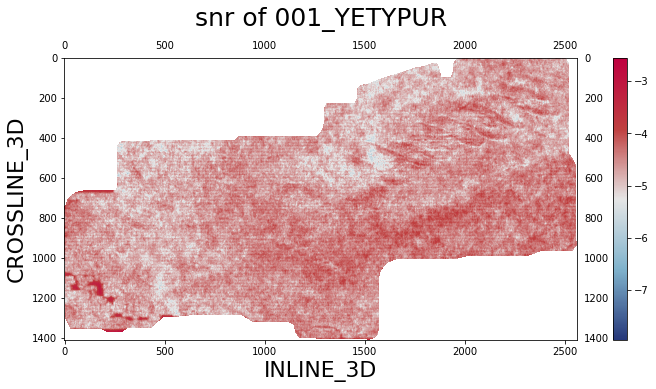

In [6]:
field.show()

In [7]:
sampler = SeismicSampler(labels=dataset.geometries, crop_shape=CROP_SHAPE,
                               threshold=0.7, shift_height=(0.7, 0.3))

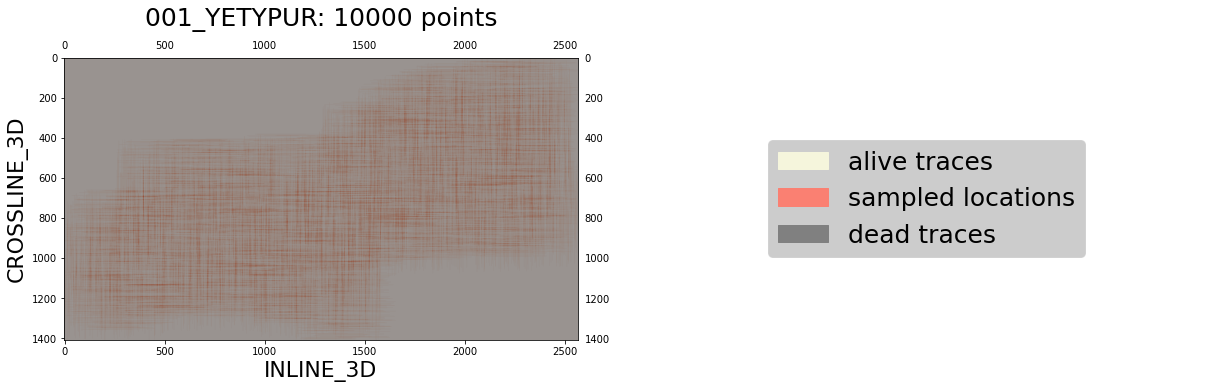

In [8]:
sampler.show_sampled()

# **Split into train and validation**

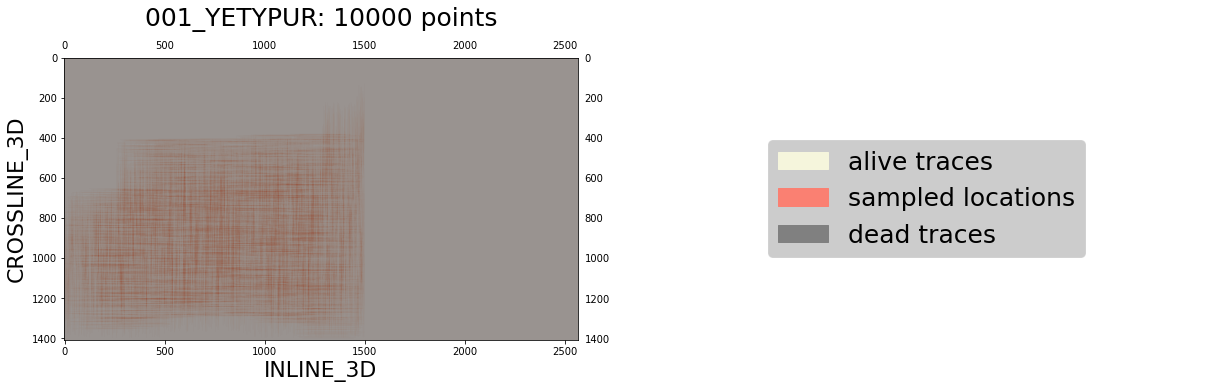

In [9]:
train_sampler = SeismicSampler(labels=dataset.geometries, crop_shape=CROP_SHAPE,
                               threshold=0.7, shift_height=(0.7, 0.3), ranges=[[0, 1500], [0, 1400], None])

train_sampler.show_sampled()

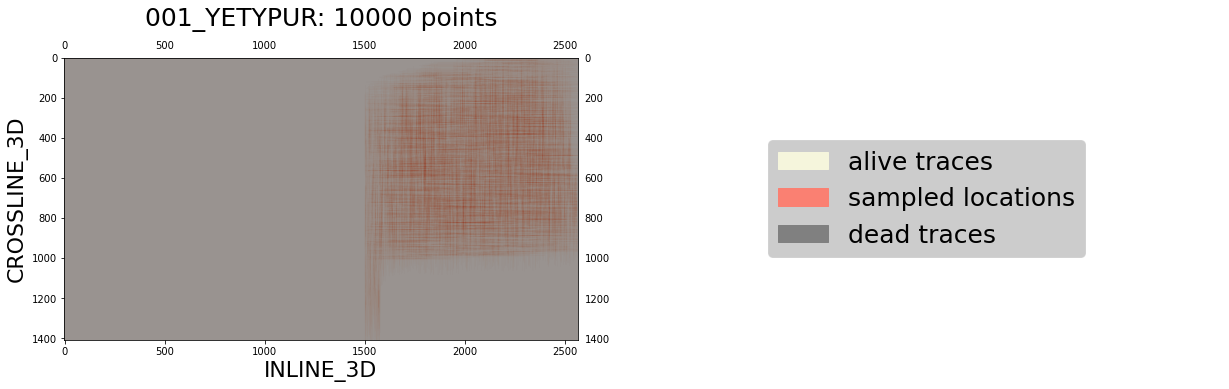

In [10]:
val_sampler = SeismicSampler(labels=dataset.geometries, crop_shape=CROP_SHAPE,
                              threshold=0.7, shift_height=(0.7, 0.3), ranges=[[1500, 2700], [0, 1500], None])

val_sampler.show_sampled()

# **Model config**
## Here is a Unet-like model (without skip between encoder and decoder) with ResBlock

In [11]:
MODEL_CONFIG = {
    'inputs_shapes': CROP_SHAPE,
                
    'order': ['encoder', 'embedding', 'decoder', 'head'], 

    'encoder': {              
        'type': 'encoder',
        'order':['blocks', 'downsample'],
        'num_stages': 2,     
        'blocks':{ #'layout': 'cnacn',
                  'channels':[64, 128], 
                  'kernel_size':3,
                  'padding': 1, 
                  'bias': False,
                  'base_block': ResBlock,
                  'n_reps': [1, 1],
                  'bottleneck': False,
                  'attention': False,
                 },
        
        'downsample': {'layout': 'p', 
                       'kernel_size': 2,
                       'stride': 2, 
                       'channels': 'same * 2'},
        'output_type': 'tensor',
    },
    'embedding': {  
        'input_type': 'tensor',
        'output_type': 'tensor',
        'layout': 'cna cna',
        'kernel_size': 3,
        'channels': 128,
    },
    'decoder': {
        'skip': False,
        'type': 'decoder',
        'num_stages': 2,
        'order': ['upsample', 'block'],
        'blocks': { #'layout':'cnacn',
                   'channels':[128, 64], 'kernel_size': 3, 
                   'stride': [1, 1], 'padding': 1, 'bias': False,
                   'base_block': ResBlock,
                   'n_reps': [1, 1],
                   'bottleneck': False,
                   'attention': False,
                  },                                      
        'upsample': {'layout': 't', 'kernel_size': 2, 'stride': 2, 'channels': 'same // 2', 'bias': True}},             
        
    'head': {                     
        'layout': 'c', 
        'channels': 1,
        'kernel_size':1,
        'stride': 1, 
        'padding': 0, 
        'bias': True},
                
    'loss': 'mse',
    # 'loss': torch.nn.KLDivLoss(), ssim
    'device': DEVICE,
    'microbatch': 1,
    'optimizer': {'name': 'Adam', 'lr': 1e-4}
    
}

In [12]:
MODEL_CONFIG_without_resblock = {'inputs_shapes': CROP_SHAPE,
                
    'order': ['encoder', 'embedding', 'decoder', 'head'], 

    'encoder': {              
        'type': 'encoder',
        'order':['blocks', 'skip', 'downsample'],
        'num_stages': 2,     
        'blocks':{'layout':'cna cna', 
                  'channels':[64, 128], 
                  'kernel_size':3,
                  'padding': 1, 
                  'stride': 1, 
                  'bias': False},   
        'downsample': {'layout': 'p', 
                       'kernel_size': 2,
                       'stride': 2, 
                       'channels': 'same * 2'},
        'output_type': 'tensor',
    },
    'embedding': {  
        'input_type': 'tensor',
        'output_type': 'tensor',
        'layout': 'cna cna',
        'kernel_size': 3,
        'channels': 256,
    },
    'decoder': {
        'skip': False,
        'type': 'decoder',
        'num_stages': 2,
        'order': ['upsample', 'blocks'],
        'blocks': {'layout':'cna cna', 'channels':[128, 64], 'kernel_size': 3, 
                   'stride': 1, 'padding': 1, 'bias': False},                                      
        'upsample': {'layout': 't', 'kernel_size': 2, 'stride': 2, 'channels': 'same // 2', 'bias': True}},              
        
    'head': {                     
        'layout': 'c', 
        'channels': 1,
        'kernel_size':1,
        'stride': 1, 
        'padding': 0, 
        'bias': True},

    'loss': 'mse',
    'device': DEVICE,
    'optimizer': {'name': 'Adam', 'lr': 1e-4}
    
}

# Train model

In [13]:
train_template = (
    Pipeline()
    # Initialize model
    .init_model(name='denoising_autoencoder', model_class=TorchModel, config=MODEL_CONFIG)
    .init_variable('loss_history', [])

    # Load data
    .make_locations(generator=train_sampler, batch_size=BATCH_SIZE)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images'])
    .normalize(src='images')
    
    # Possible augmentations
    .additive_noise(scale=0.05,
                    src='images', dst='images_anoise')

    # Training
    .train_model('denoising_autoencoder',
                 inputs=B('images_anoise'), targets=B('images'),
                 outputs='loss', save_to=V('loss_history', mode='a'))
)

train_pipeline = train_template << dataset

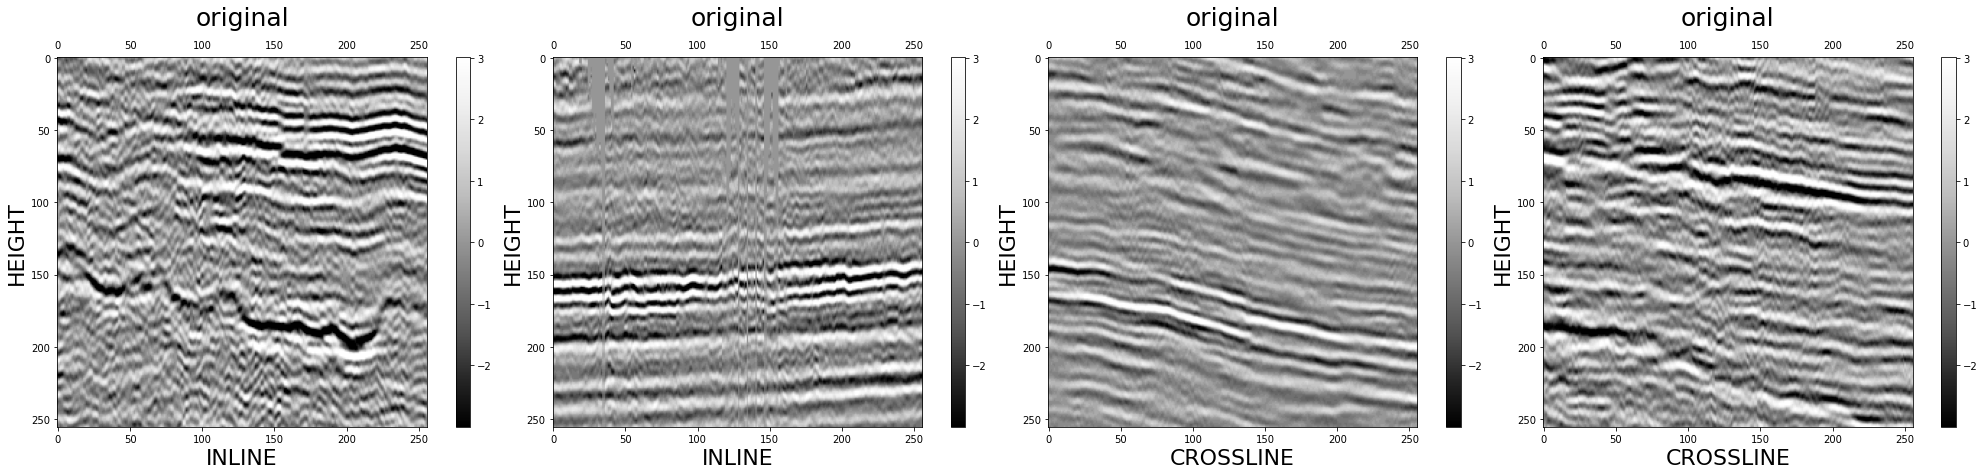

In [14]:
batch = train_pipeline.next_batch()

batch.plot_roll(n=4, ncols=4, combine='separate', colorbar=True, labelright=False, title='original')

In [15]:
notifier = Notifier('t', monitors=['loss_history', 'gpu', 'gpu_memory'])

train_pipeline.run(n_iters=N_ITERS, notifier=notifier)

100%|██████████████████████████████████████████████████| 300/300 [03:56<00:00,  1.27it/s, loss_history=0.0312]


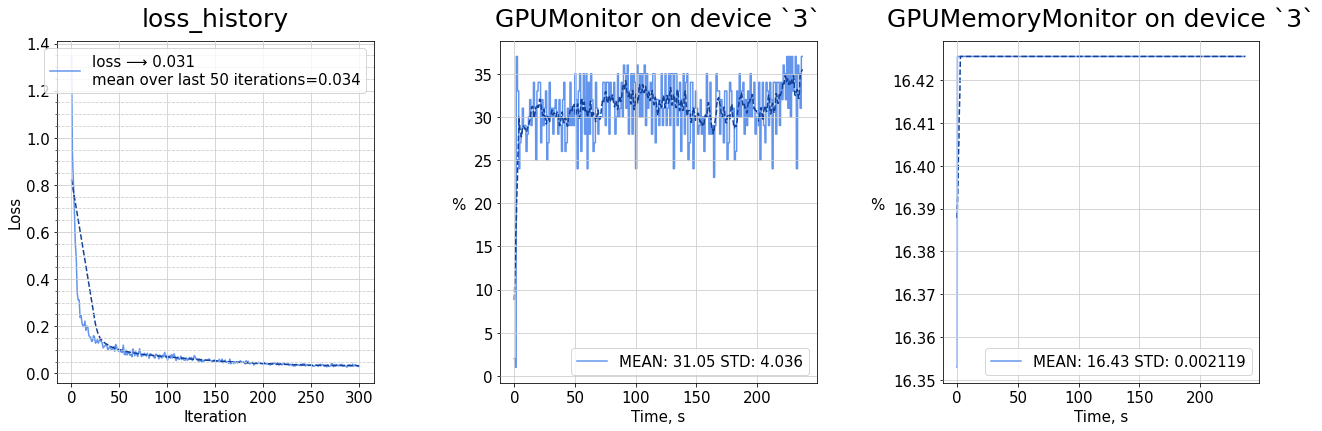

In [16]:
notifier.plot()

# Save model

In [17]:
train_pipeline.save_model_now('denoising_autoencoder', 'saved_models/denoise_model')

# Validation part

In [18]:
model = train_pipeline.m('denoising_autoencoder')

val_template = (
    Pipeline()
    # Import model
    .import_model(name='denoising_autoencoder', source=model)

    # Load data
    .make_locations(generator=val_sampler, batch_size=BATCH_SIZE)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images'])
    .normalize(src='images')

    # Predict with model
    .predict_model('denoising_autoencoder',
                   inputs=B('images'),
                   outputs='predictions',
                   save_to=B('predictions'))

)
val_pipeline = val_template << dataset

In [19]:
val_batch = val_pipeline.next_batch()

[ValueError('could not broadcast input array from shape (234,256) into shape (256,256)')]


  File "/notebooks/22/batchflow/batchflow/decorators.py", line 432, in wrap_with_for
    one_ft = call_method(method, use_self, margs, mkwargs, seed=seed)
  File "/notebooks/22/batchflow/batchflow/decorators.py", line 185, in call_method
    return method(*args, **kwargs)
  File "/notebooks/22/../seismiqb/seismiqb/batch/crop_batch.py", line 265, in load_cubes
    return field.load_seismic(location=location, native_slicing=native_slicing, src=src_geometry, **kwargs)
  File "/notebooks/22/../seismiqb/seismiqb/field/base.py", line 277, in load_seismic
    seismic_crop = geometry.load_crop(location, **kwargs)
  File "/notebooks/22/../seismiqb/seismiqb/geometry/converted.py", line 103, in load_crop
    crop = method(buffer, cube, *locations, **kwargs)
  File "/notebooks/22/../seismiqb/seismiqb/geometry/converted.py", line 113, in _load_0
    buffer[i] = self._cached_load(cube, iline, **kwargs)[xlines, :][:, heights]


RuntimeError: Could not assemble the batch

In [ ]:
val_batch.plot_roll(n=3, ncols=3, combine='separate', colorbar=True, cmap='Greys_r')

# Calculate metrics

In [ ]:
import torch
from torchmetrics import StructuralSimilarityIndexMeasure, UniversalImageQualityIndex, MeanSquaredError, PearsonCorrCoef, PeakSignalNoiseRatio
import matplotlib.pyplot as plt
import pandas as pd

preds = torch.from_numpy(val_batch.predictions)
target = torch.from_numpy(val_batch.images)

ssim = StructuralSimilarityIndexMeasure()
uqi = UniversalImageQualityIndex()
mse = MeanSquaredError()

metrics = {'ssim': ssim, 'uqi': uqi, 'mse': mse}

def metrics_values(metrics: list):
    d = {}
    for key, value in metrics.items():
        d[key] = [round(value(preds, target).item(), 5)]
    return pd.DataFrame(d, index=['unet_resblock model'])

metrics_values(metrics)

In [ ]:
# посчитать Фурье, удалить высокую частоту и посчитать обратное преобразование Фурье

In [ ]:
pear_corr = PearsonCorrCoef()
print('Pearson correlation between two images')
pear_corr(target[0].reshape(-1), preds[0].reshape(-1)).item()

In [ ]:
# Difference between target and predicted images
for i in range(3):
    image_pred = preds[i].detach().cpu().numpy().squeeze()
    image_target = target[i].detach().cpu().numpy().squeeze()
    image_diff = image_pred - image_target
    plot([image_target, image_pred, image_diff], title=['target', 'predicted', 'difference'], 
          combine='separate', colorbar=True)

In [ ]:
t = StructuralSimilarityIndexMeasure(reduction=None, kernel_size=3)
t(target, preds)

In [ ]:
image_noise = image_target - image_pred

In [ ]:
# Fourier
fourier_target = np.fft.fft2(image_target.T)
fourier_pred = np.fft.fft2(image_pred.T)

In [ ]:
# def phase_correlation(fourier_target, fourier_pred):
#     conj_pred = np.conjugate(fourier_pred)
#     phase_correlation = (fourier_target * conj_pred) / np.abs(fourier_target * conj_pred)
#     phase_correlation = np.abs(np.fft.ifft2(phase_correlation))
#     return phase_correlation

# plt.imshow(phase_correlation(fourier_target, fourier_pred))
# plt.title('Phase correlation between target and predicted');

In [ ]:
import scipy

plt.imshow(scipy.signal.correlate2d(target[0].detach().cpu().numpy().squeeze(), preds[0].detach().cpu().numpy().squeeze(), mode='same'), cmap='gray')
plt.title('Cross-correlation between two images')

In [ ]:
# phase spectrum
predicted_phase = np.log(np.fft.fftshift(np.angle(fourier_pred)))
target_phase = np.log(np.fft.fftshift(np.angle(fourier_target)))

In [ ]:
# power spectrum
predicted_power = np.log(np.fft.fftshift(np.abs(fourier_pred**2)))
target_power = np.log(np.fft.fftshift(np.abs(fourier_target**2)))

In [ ]:
plot([image_target, target_power, target_phase], 
     title=['target image', 'target power spectrum', 'target phase spectrum'], combine='separate', cmap=plt.cm.jet)
plot([image_pred, predicted_power, predicted_phase],
     title=['predicted image', 'predicted power spectrum', 'predicted phase spectrum'], combine='separate', cmap=plt.cm.jet)

In [ ]:
class Window_metrics:
    def __init__(self, window_size, image_pred, image_noise, shape=(256, 256)):
        self.window_size = window_size
        self.image_pred = image_pred
        self.image_noise = image_noise
        self.shape = shape
        
    def corr_pearson(self, x, y):
        x_m = x - np.mean(x, axis=1)[:,None]
        y_m = y - np.mean(y, axis=1)[:,None]

        X = (x_m**2).sum(axis=1)
        Y = (y_m**2).sum(axis=1)

        corr = ((x_m * y_m).sum(axis=1) / np.sqrt(X * Y)) ** 2
        return corr
    
    def pad_images(self):
        pad_width = [[self.window_size // 2, self.window_size // 2], 
                     [self.window_size // 2, self.window_size // 2]]
        predicted = np.pad(self.image_pred, pad_width=pad_width, mode='mean')
        noise = np.pad(self.image_noise, pad_width=pad_width, mode='mean')
        return predicted, noise
    
    def windows_correlation(self):
    
        image_pred_padded, image_noise_padded = self.pad_images()
        image_pred_windows = np.lib.stride_tricks.sliding_window_view(image_pred_padded, 
                                                                      window_shape=(self.window_size, self.window_size))
        image_noise_windows = np.lib.stride_tricks.sliding_window_view(image_noise_padded, 
                                                                       window_shape=(self.window_size, self.window_size))
        squeeze_shape = (np.dot(*image_pred_windows.shape[:2]), np.dot(*image_pred_windows.shape[2:]))
        pred_windows = image_pred_windows.reshape(squeeze_shape)
        noise_windows = image_noise_windows.reshape(squeeze_shape)
        window_corr = self.corr_pearson(pred_windows, noise_windows).reshape(self.shape)
        return np.nan_to_num(window_corr)
    
    def get_pearson(self):
        """ Get correlation between two images. """
        return self.corr_pearson(self.image_pred, self.image_noise).mean()
    
    def local_uqi(self, preds, target):
        # Local UQI
        image_index = [5, 12]
        for img in image_index:
            for k_s in [3, self.window_size]:
                uiqi2 = UniversalImageQualityIndex(reduction=None, kernel_size=(k_s, k_s))
                metric_uiqi2 = uiqi2(preds, target-preds)[img].detach().cpu().numpy().squeeze()
                metric_uiqi_target_pred = uiqi2(target, preds)[img].detach().cpu().numpy().squeeze()
                plot([metric_uiqi2, metric_uiqi_target_pred], 
                      title=[f'UQI pred/noise img_{img}', f'UQI target/pred img_{img}'], 
                      combine='separate', colorbar=True, cmap=plt.cm.jet)

In [ ]:
Window_metrics(window_size=11, image_pred=image_pred, image_noise=image_noise).get_pearson()

In [ ]:
print('UQI between predicted and noise:', uqi(preds, target-preds).item())
Window_metrics(window_size=11, image_pred=image_pred, image_noise=image_noise).local_uqi(preds, target)

In [ ]:
window_11 = Window_metrics(window_size=11, image_pred=image_pred, image_noise=image_noise).windows_correlation()
window_5 = Window_metrics(image_pred=image_pred, image_noise=image_noise, window_size=5).windows_correlation()

In [ ]:
plot([window_5, window_11], title=['window_size 5', 'window_size 11'], 
      combine='separate', colorbar=True, cmap=plt.cm.jet)

# **Inference part**

In [ ]:
inference_template = (
    Pipeline()
    # Import model
    .import_model(name='denoising_autoencoder', source=model)

    # Load data
    .make_locations(generator=C('grid'))
    .load_cubes(dst='images')
    .adaptive_reshape(src='images')
    .normalize(src='images')

    # Predict with model, then aggregate
    .predict_model('denoising_autoencoder', inputs=B('images'),
                   outputs='predictions', save_to=B('predictions'))
    .update_accumulator(src='predictions', accumulator=C('accumulator'))
)

In [ ]:
%%time
ranges = [None, None, None]

grid = RegularGrid(field=field, orientation=0, ranges=ranges,
                   overlap_factor=1.1, batch_size=BATCH_SIZE*4, crop_shape=CROP_SHAPE)


accumulator = Accumulator3D.from_grid(grid=grid, aggregation='mean', fill_value=0.0)

inference_pipeline = inference_template << dataset << {'grid': grid, 'accumulator': accumulator}

In [ ]:
%%time
inference_pipeline.run(n_iters=grid.n_iters, bar='n')

In [ ]:
aggregated = accumulator.aggregate()
aggregated.shape

In [ ]:
# horizons = Horizon.from_mask(aggregated, field=field, origin=grid.origin,
#                              minsize=10000)

# predicted_horizon = horizons[-1] 
# predicted_horizon.show()

In [ ]:
horizons = Horizon.from_mask(aggregated, field=field, origin=grid.origin)
                             # minsize=10)

predicted_horizon = horizons[-1] 
predicted_horizon.show()